# Trabalho redes Complexas

Luciano Augusto Campagnoli da Silva 9313367
Laura Gouveia

## Introdução


Em sistemas complexos, o tráfego e a comunicação entre suas partes são de extrema importância para manter seu funcionamento. Vide o caso de células, em que moléculas orgâncias são transportadas por vias tubulares entre seus componentes para interagir com outras [1].  É possível analisar cidades representadas como redes complexas, interpretando como comunicação a circulação de pessoas por ela.

Este trabalho analisa o tráfego em redes complexas sob a perspectiva da informação necessária para deslocar entre ruas de uma cidade, utilizando uma rede alternativa para representá-la. As próximas seções são dispostas da seguinte maneira: na seção **Referencial Teórico**, discute-se acerca das referências na qual o escopo técnico deste projeto se baseia; na Seção **Métodos**, são descritos os processos e experimentos realizados, cujos resultados são exibidos em **Resultados e discussões**. Finaliza-se com a **Conclusão**, que sumariza as realizações atingidas e possibilidades a ser exploradas em trabalhos futuros.





## Referencial teórico

As técnicas deste trabalho são baseadas em [2], que propõe a análise de tráfego em cidades baseada na facilidade de fluxo de informações por suas vias. Para tanto, cria-se para elas uma representação em forma de grafos não direcionados, nos quais os vértices representam suas vias e as arestas as intersecções entre elas (contrariando o que convencionalmente poder-se-ia imaginar). Para simplificação, pressupõe-se que os custos de se movimentar pelas vias (ou de trocar de uma para outra) sejam uniformes, o que implicaria que o grafo seria não ponderado. O conceito é ilustrado pelas Figuras 1 e 2:

[Figura 1: Representação de rede de informação em uma cidade fictícia em formato de estrela](./cidade_estrela.png)
[Figura 2: Representação de rede de informação em uma cidade fictícia em formato de grade](./cidade_grelha.png)

Em uma rede seguindo a estrutura proposta, pretende-se alcançar uma via **t** partindo de **s** através do(s) menor(es) caminho(s). Para tanto, a probabilidade de seguir um deles é dada por:


$$P[p(s,t)] = \frac{1}{k_{s}}\prod_{j \in p(s,t)}^{}\frac{1}{k_{j} - 1}$$   (1)


, na qual **j** representa todos os nós da trajetória antes de atingir o destino. O fator **kj - 1** , em contrapartida a **kj**, representa o ganho de informação ao seguir uma das saídas do nó (reduzindo as possibilidades em uma unidade). A probabilidade de seguir qualquer um dos caminhos mais curtos, portanto, dá-se pela soma das de cada um deles:

$$P(s -> t) = \sum_{}^{}P[p(s,t)]$$ (2).





In [ ]:
import networkx as nx
import osmnx as ox
import pandas as pd
import numpy as np
import time


*Download* das redes.

In [ ]:
corumbatai = ox.graph_from_place("Corumbataí, Brazil")
guara = ox.graph_from_place("Guará, Brazil")
sao_caetano = ox.graph_from_place("São Caetano do Sul, Brazil")


In [ ]:
sao_caetano.number_of_nodes(), sao_caetano.number_of_edges()

(3903, 9392)

Função para renomear nós com seus índices.

In [ ]:
def rename_nodes(graph: nx.Graph):
  mapping = {}
  count = 0

  for node in graph.nodes():
      mapping[node] = count
      count += 1

  return nx.relabel_nodes(graph, mapping)

Obtenção das redes duais.

In [ ]:
[corumbatai_dual, guara_dual, sao_caetano_dual] = [
    rename_nodes(
        nx.line_graph(graph).to_undirected()
    ) for graph in [corumbatai, guara, sao_caetano]
]

sao_caetano_dual.number_of_nodes(), sao_caetano_dual.number_of_edges()



(9392, 21388)

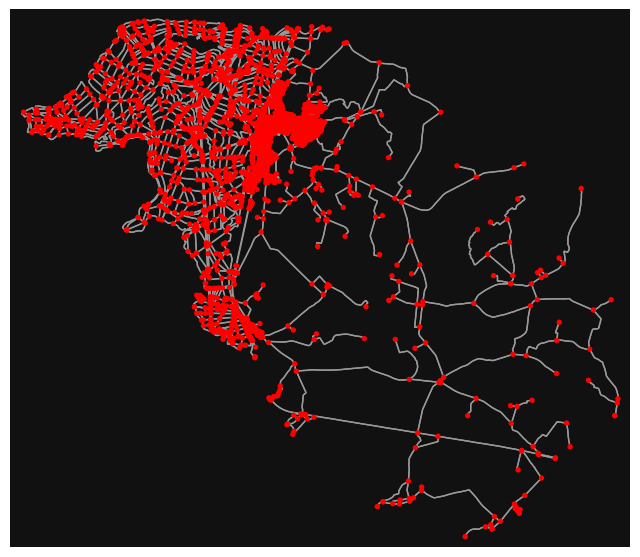

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
ox.plot_graph(guara, node_color="red")


Métrica Search-Information.

In [ ]:
def search_information(sp, adjacency, has_memory=False):
    start_time = time.time()
    print("Começo: ", time.ctime(start_time))



    N = len(adjacency)

    flag_triu = np.allclose(adjacency, adjacency.T)

    T = np.linalg.solve(np.diag(np.sum(adjacency, axis=1)), adjacency)
    print("Resolveu o sistema")

    SI = np.zeros((N, N))
    SI[np.eye(N) > 0] = np.nan

    for i in range(N):
        if (N % 1000 == 0):
            print("Nó ", N)

        for j in range(N):
            if (j > i and flag_triu) or (not flag_triu and i != j):
                path = sp[i][j]
                lp = len(path) - 1

                if flag_triu:
                    if np.any(path):
                        pr_step_ff = np.zeros(lp)
                        pr_step_bk = np.zeros(lp)

                        if has_memory:
                            pr_step_ff[0] = T[path[0], path[1]]
                            pr_step_bk[lp-1] = T[path[lp], path[lp-1]]
                            for z in range(1, lp):
                                pr_step_ff[z] = T[path[z], path[z+1]] / (1 - T[path[z-1], path[z]])
                                pr_step_bk[lp-z-1] = T[path[lp-z], path[lp-z-1]] / (1 - T[path[lp-z+1], path[lp-z]])
                        else:
                            for z in range(lp):
                                pr_step_ff[z] = T[path[z], path[z+1]]
                                pr_step_bk[z] = T[path[z+1], path[z]]

                        prob_sp_ff = np.prod(pr_step_ff)
                        prob_sp_bk = np.prod(pr_step_bk)

                        SI[i, j] = -np.log2(prob_sp_ff)
                        SI[j, i] = -np.log2(prob_sp_bk)
                else:
                    if np.any(path):
                        pr_step_ff = np.zeros(lp)
                        if has_memory:
                            pr_step_ff[0] = T[path[0], path[1]]
                            for z in range(1, lp):
                                pr_step_ff[z] = T[path[z], path[z+1]] / (1 - T[path[z-1], path[z]])
                        else:
                            for z in range(lp):
                                pr_step_ff[z] = T[path[z], path[z+1]]

                        prob_sp_ff = np.prod(pr_step_ff)
                        SI[i, j] = -np.log2(prob_sp_ff)
                    else:
                        SI[i, j] = np.inf

    print("SI calculado com sucesso! Tempo: ", time.time() - start_time)
    return SI


Access Information.

In [ ]:
def access_information(search_information_matrix):
  search_information_matrix = np.nan_to_num(search_information_matrix, nan=0)
  sf_size = len(search_information_matrix)

  AI = []

  for index in range(len(search_information_matrix)):
    AI.append(
        np.nan_to_num(search_information_matrix[index], nan=0).sum()/sf_size
    )

  return AI


In [ ]:
corumbatai_search_information_matrix = search_information(corumbatai_dual, False)
corumbatai_si_df = pd.DataFrame(corumbatai_search_information_matrix)
corumbatai_si_df

Começo:  Mon Jun 23 20:47:13 2025


<class 'networkx.utils.decorators.argmap'> compilation 34:3: FutureWarning: 

shortest_path will return an iterator that yields
(node, path) pairs instead of a dictionary when source
and target are unspecified beginning in version 3.5

To keep the current behavior, use:

	dict(nx.shortest_path(G))


SI calculado com sucesso! Tempo:  9.311583280563354


,0,1,2,3,4,5,6,7,8,9,...,968,969,970,971,972,973,974,975,976,977
0,NaN,2.000000,3.000000,19.924813,21.924813,21.924813,10.000000,8.000000,12.000000,18.339850,...,60.286559,24.609640,-0.000000,22.924813,25.398744,26.661778,32.101494,25.076816,23.076816,30.516531
1,3.000000,NaN,1.000000,17.924813,19.924813,19.924813,11.000000,9.000000,13.000000,19.339850,...,58.286559,25.609640,1.000000,20.924813,26.398744,27.661778,33.101494,26.076816,24.076816,31.516531
2,5.000000,2.000000,NaN,16.924813,18.924813,18.924813,13.000000,11.000000,15.000000,21.339850,...,57.286559,27.609640,3.000000,19.924813,28.398744,29.661778,36.067278,28.076816,26.076816,34.482315
3,21.924813,18.924813,16.924813,NaN,2.000000,2.000000,24.339850,27.720672,26.339850,20.584963,...,70.211371,41.745350,19.509775,3.000000,26.228819,27.491853,25.491853,25.906891,23.906891,23.906891
4,22.924813,19.924813,17.924813,1.000000,NaN,3.000000,22.339850,25.720672,24.339850,18.584963,...,71.211371,39.745350,20.509775,1.000000,24.228819,25.491853,23.491853,23.906891,21.906891,21.906891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,27.661778,27.661778,28.661778,26.491853,25.491853,25.491853,15.661778,17.661778,17.661778,11.906891,...,81.709980,28.831703,25.661778,23.491853,9.228819,NaN,1.000000,1.000000,2.584963,2.000000
974,33.101494,33.101494,35.067278,24.491853,23.491853,23.491853,17.661778,19.661778,19.661778,13.906891,...,79.709980,30.831703,31.101494,21.491853,6.906891,1.000000,NaN,2.000000,3.584963,1.000000
975,26.661778,26.661778,27.661778,25.491853,24.491853,24.491853,14.661778,16.661778,16.661778,10.906891,...,80.709980,27.831703,24.661778,22.491853,8.228819,1.584963,2.584963,NaN,1.584963,1.584963
976,25.076816,25.076816,26.076816,23.906891,22.906891,22.906891,13.076816,15.076816,15.076816,9.321928,...,79.125018,26.246741,23.076816,20.906891,6.643856,3.584963,4.584963,2.000000,NaN,4.000000


In [ ]:
corumbatai_si_df.to_csv("corumbatai.csv")

In [ ]:
sp = dict(nx.shortest_path(guara_dual))
adjacency = nx.adjacency_matrix(guara_dual).todense()

guara_search_information_matrix = search_information(sp=sp, adjacency=adjacency, has_memory=True)
guara_si_df = pd.DataFrame(guara_search_information_matrix)
guara_si_df

Começo:  Mon Jun 23 23:03:40 2025
Resolveu o sistema


C:\Users\lucia\AppData\Local\Temp\ipykernel_8664\2975086080.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  pr_step_bk[lp-z-1] = T[path[lp-z], path[lp-z-1]] / (1 - T[path[lp-z+1], path[lp-z]])
C:\Users\lucia\AppData\Local\Temp\ipykernel_8664\2975086080.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  pr_step_ff[z] = T[path[z], path[z+1]] / (1 - T[path[z-1], path[z]])


SI calculado com sucesso! Tempo:  791.8195059299469


,0,1,2,3,4,5,6,7,8,9,...,7676,7677,7678,7679,7680,7681,7682,7683,7684,7685
0,NaN,1.584963,1.584963,2.584963,5.000000,14.339850,13.339850,15.924813,17.094738,17.094738,...,50.243900,50.243900,50.799115,48.799115,48.799115,48.185007,31.586591,33.323556,33.323556,33.323556
1,2.321928,NaN,3.584963,4.584963,4.000000,13.339850,12.339850,14.924813,16.094738,16.094738,...,49.243900,49.243900,49.799115,47.799115,47.799115,47.185007,30.586591,32.323556,32.323556,32.323556
2,2.000000,3.169925,NaN,4.169925,6.584963,15.924813,14.924813,17.509775,18.679700,18.679700,...,51.828863,51.828863,52.384078,50.384078,50.384078,49.769969,33.171553,34.908519,34.908519,34.908519
3,1.584963,2.584963,2.584963,NaN,1.000000,12.509775,11.509775,14.094738,15.264663,15.264663,...,45.658938,45.658938,46.214153,44.214153,44.214153,43.600044,27.001628,28.738594,28.738594,28.738594
4,5.491853,3.584963,6.754888,2.000000,NaN,12.509775,11.509775,14.094738,15.264663,15.264663,...,45.658938,45.658938,46.214153,44.214153,44.214153,43.600044,27.001628,28.738594,28.738594,28.738594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7681,49.243900,47.337010,50.506935,45.752047,44.752047,40.505307,41.090269,42.412197,40.675232,40.675232,...,2.321928,2.321928,6.321928,4.321928,4.321928,NaN,30.679700,31.323556,29.509775,30.908519
7682,32.323556,30.416666,33.586591,28.831703,27.831703,35.416666,34.416666,37.001628,38.171553,38.171553,...,30.416666,30.416666,26.738594,27.060522,27.060522,30.416666,NaN,2.321928,2.321928,2.321928
7683,33.323556,31.416666,34.586591,29.831703,28.831703,36.416666,35.416666,38.001628,39.171553,39.171553,...,28.645484,28.645484,26.323556,26.645484,26.645484,30.230447,1.584963,NaN,3.321928,3.321928
7684,33.323556,31.416666,34.586591,29.831703,28.831703,36.416666,35.416666,38.001628,39.171553,39.171553,...,28.416666,28.416666,26.831703,27.153631,27.153631,28.416666,1.584963,3.321928,NaN,3.321928


In [ ]:
guara_si_df.to_csv("guara.csv")

In [ ]:
sp = dict(nx.shortest_path(sao_caetano_dual))
adjacency = nx.adjacency_matrix(sao_caetano_dual).todense()

sao_caetano_search_information_matrix = search_information(sp=sp, adjacency=adjacency, has_memory=True)
sao_caetano_si_df = pd.DataFrame(sao_caetano_search_information_matrix)
sao_caetano_si_df

Começo:  Tue Jun 24 00:20:19 2025
Resolveu o sistema


C:\Users\lucia\AppData\Local\Temp\ipykernel_10852\2975086080.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  pr_step_bk[lp-z-1] = T[path[lp-z], path[lp-z-1]] / (1 - T[path[lp-z+1], path[lp-z]])
C:\Users\lucia\AppData\Local\Temp\ipykernel_10852\2975086080.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  pr_step_ff[z] = T[path[z], path[z+1]] / (1 - T[path[z-1], path[z]])


SI calculado com sucesso! Tempo:  1289.0166945457458


,0,1,2,3,4,5,6,7,8,9,...,9382,9383,9384,9385,9386,9387,9388,9389,9390,9391
0,NaN,2.000000,2.000000,2.000000,3.584963,5.169925,5.169925,10.339850,8.924813,11.924813,...,123.469278,122.113134,121.469278,121.469278,71.589847,74.437844,74.437844,70.700878,72.437844,74.437844
1,2.000000,NaN,3.584963,3.584963,2.000000,3.584963,3.584963,11.924813,10.509775,18.042600,...,123.791206,122.435062,121.791206,121.791206,73.174809,76.022806,76.022806,72.285841,74.022806,76.022806
2,2.321928,4.000000,NaN,4.000000,5.584963,4.584963,7.169925,12.339850,10.924813,18.457637,...,121.884315,120.528171,119.884315,119.884315,73.589847,76.437844,76.437844,72.700878,74.437844,76.437844
3,2.321928,4.000000,4.000000,NaN,5.584963,4.584963,7.169925,12.339850,10.924813,17.720672,...,124.206243,122.850100,122.206243,122.206243,73.589847,76.437844,76.437844,72.700878,74.437844,76.437844
4,3.584963,2.000000,5.169925,5.169925,NaN,2.000000,2.000000,10.339850,8.924813,11.924813,...,123.054240,121.698096,121.054240,121.054240,71.589847,74.437844,74.437844,70.700878,72.437844,74.437844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9387,74.945991,76.530953,76.530953,76.530953,74.945991,76.530953,76.530953,68.191103,69.776066,69.776066,...,71.822165,69.822165,69.822165,69.822165,56.645484,NaN,4.321928,4.321928,2.321928,4.321928
9388,73.945991,75.530953,75.530953,75.530953,73.945991,75.530953,75.530953,67.191103,68.776066,68.776066,...,74.822165,72.822165,72.822165,72.822165,55.645484,3.321928,NaN,3.321928,1.584963,3.321928
9389,70.945991,72.530953,72.530953,72.530953,70.945991,72.530953,72.530953,64.191103,65.776066,65.776066,...,75.407128,73.407128,73.407128,73.407128,52.645484,4.321928,4.321928,NaN,2.321928,4.321928
9390,71.945991,73.530953,73.530953,73.530953,71.945991,73.530953,73.530953,65.191103,66.776066,66.776066,...,72.822165,70.822165,70.822165,70.822165,53.645484,1.584963,1.584963,1.584963,NaN,5.321928


In [ ]:
sao_caetano_si_df.to_csv("sao_caetano_2.csv")

In [ ]:
def average_search_information(search_information_matrix):
  return np.nan_to_num(search_information_matrix, nan=0).sum()/(len(search_information_matrix)) ** 2

In [ ]:
sao_carlos_ai = access_information(sao_carlos_sf)

sao_carlos_ai_df = pd.DataFrame(sao_carlos_ai)
sao_carlos_ai_df

,0
0,36.223631
1,35.480443
2,35.586390
3,46.706414
4,46.466626
...,...
973,51.597506
974,50.032211
975,50.603390
976,49.033514


In [ ]:
avg_sao_carlos_sf = average_search_information(sao_carlos_sf)
avg_sao_carlos_sf

np.float64(39.64915892450188)

Entropia de alvo.

In [ ]:
def neighbor_path_fraction(graph, target_node):
    """
    Calculates the fraction of shortest paths to a target node which pass through each of its neighbors.

    Args:
        graph: A NetworkX graph.
        target_node: The target node.

    Returns:
        A dictionary where keys are neighbors of the target node and values
        are the fraction of shortest paths from all other nodes to the target
        node that pass through that neighbor.
    """
    path_counts = {}
    for neighbor in graph.neighbors(target_node):
        path_counts[neighbor] = 0

    # Get shortest paths from all other nodes to the target node
    shortest_paths = nx.shortest_path(graph, target=target_node)

    # Iterate through all source nodes (excluding the target node)
    for source_node, path in shortest_paths.items():
        if source_node != target_node:
            # Check if the path has more than one node (not a direct connection)
            if len(path) > 1:
                # The next node in the path from the source towards the target
                next_node = path[1]
                if next_node in path_counts:
                    path_counts[next_node] += 1

    total_paths = sum(path_counts.values())

    neighbor_fractions = {}
    for neighbor, count in path_counts.items():
        if total_paths > 0:
            neighbor_fractions[neighbor] = count / total_paths
        else:
            neighbor_fractions[neighbor] = 0 # Handle case where no other nodes exist or are directly connected

    return neighbor_fractions


In [ ]:
# prompt: Calculate the fraction of shortest paths that passess through a pair o

def edge_betweenness_fraction(graph, node1, betweenness_centrality):
    """
    Calculates the fraction of all-pairs shortest paths that pass through the edge (node1, node2).

    Args:
        graph: A NetworkX graph.
        node1: The first node of the edge.
        node2: The second node of the edge.

    Returns:
        The fraction of shortest paths passing through the edge (node1, node2).
    """
    # Ensure the edge exists in the graph

    fractions = []

    for node2 in graph.neighbors(node1):

      # The betweenness centrality for an edge (u, v) is the sum over all
      # pairs of distinct nodes (s, t) of the number of shortest (s, t) paths
      # that pass through (u, v), divided by the number of all shortest (s, t) paths.
      # The edge_betweenness_centrality function returns the normalized version
      # where the denominator is the number of pairs of distinct nodes (n*(n-1)/2 for undirected).

      # We need the unnormalized betweenness to find the fraction of paths.
      # The normalization factor for edge betweenness in an undirected graph is (n * (n - 1)) / 2.
      n = graph.number_of_nodes()
      normalization_factor = (n * (n - 1)) / 2.0

      unnormalized_betweenness = betweenness_centrality.get((node1, node2, 0), betweenness_centrality.get((node2, node1, 0), 0)) * normalization_factor



      # The total number of shortest paths between all pairs of nodes is not directly
      # returned by networkx betweenness centrality.
      # A simpler approach for fraction is to sum the unnormalized betweenness for all edges
      # and divide the target edge's unnormalized betweenness by this sum.
      # However, this is only valid if every shortest path contributes 1 to the sum of
      # betweenness values of edges it traverses, which is true.

      # Let's compute the sum of unnormalized betweenness for all edges
      total_unnormalized_betweenness = sum(betweenness_centrality.values()) * normalization_factor

      if total_unnormalized_betweenness > 0:
          fraction = unnormalized_betweenness / total_unnormalized_betweenness
      else:
          fraction = 0.0 # Handle cases with no paths (e.g., disconnected graph)

      fractions.append(fraction)

    return fractions

# Example usage:
# Replace node_u and node_v with two nodes from your graph sao_carlos
# You can find node IDs using sao_carlos.nodes
# node_u = list(sao_carlos.nodes)[0]
# node_v = list(sao_carlos.nodes)[1]
# fraction = edge_betweenness_fraction(sao_carlos, node_u, node_v)
# print(f"Fraction of shortest paths through edge ({node_u}, {node_v}): {fraction}")


# If you want the fraction of paths passing *through* two nodes sequentially
# (i.e., paths of the form A -> node1 -> node2 -> B), this is more complex
# and not directly captured by standard betweenness.
# The question "passes through two specific nodes" can be interpreted as
# passing through the edge connecting them. The function above calculates this.



In [ ]:
def target_entropy(graph: nx.Graph):
  TE = []

  for node in graph.nodes():
    # Count all the shortest paths that goes to node
    neighbor_fractions = neighbor_path_fraction(graph, node)

    # Calculate the entropy
    entropy = 0
    for neighbor, fraction in neighbor_fractions.items():
      entropy += fraction * np.log2(fraction)

    TE.append(-1 * entropy)

  return TE




In [ ]:
def target_entropy_medium(adjacency):
  TE = []

  for node in adjacency:
    # Count all the shortest paths that goes to node

    degree = node.sum()

    TE.append(- degree * 1/degree * np.log2(1/degree))

  return TE




Road entropy metric.

In [ ]:
def road_entropy(graph: nx.Graph):
  RE = []

  count = 0

  betweeness_centrality = nx.edge_betweenness_centrality(graph)
  print(betweeness_centrality)

  for node in graph:
    entropy = 0

    betweeness_fraction = edge_betweenness_fraction(graph, node, betweeness_centrality)

    for fraction in betweeness_fraction:
      if fraction != 0: entropy += fraction * np.log2(fraction)

    RE.append(-1 * entropy)
    count += 1

  return RE

In [ ]:
te_df = pd.DataFrame(target_entropy(corumbatai_dual))
te_df

<ipython-input-139-2560203283>:11: RuntimeWarning: divide by zero encountered in log2
  entropy += fraction * np.log2(fraction)
<ipython-input-139-2560203283>:11: RuntimeWarning: invalid value encountered in scalar multiply
  entropy += fraction * np.log2(fraction)


,0
0,-0.000000
1,1.000000
2,1.905639
3,NaN
4,0.970951
...,...
973,1.000000
974,1.000000
975,NaN
976,1.905639


In [ ]:
tf_df_medium = pd.DataFrame(target_entropy_medium(nx.adjacency_matrix(corumbatai_dual).todense()))
tf_df_medium

,0
0,-0.000000
1,1.000000
2,2.000000
3,2.000000
4,1.000000
...,...
973,1.000000
974,1.000000
975,1.584963
976,2.000000


In [ ]:
rf_df = pd.DataFrame(road_entropy(guara_dual))
rf_df

{(0, 1, 0): 0.0006716590222940891, (0, 2, 0): 0.0003501812715073848, (0, 3121, 0): 0.0002699380783497444, (1, 42, 0): 0.0009649872939873678, (1, 43, 0): 0.0010933483157819957, (1, 44, 0): 0.0013544518442599423, (1, 3123, 0): 0.00222339993121361, (2, 3119, 0): 0.0003778159217677303, (2, 3120, 0): 0.00011999366477011714, (2, 3123, 0): 0.0002927751247843851, (3, 4, 0): 0.001001155969373089, (3, 3121, 0): 0.0007424605124804626, (4, 95, 0): 0.021287340348683317, (4, 96, 0): 0.0024349722105677244, (4, 44, 0): 0.023165874721840115, (5, 6, 0): 0.083438110641913, (5, 2312, 0): 0.08345878096507024, (6, 2345, 0): 0.08240665327394547, (6, 2346, 0): 0.009143280136563271, (6, 2340, 0): 0.0016532122488958354, (7, 8, 0): 0.0011392851592599354, (7, 9, 0): 0.0002814585647125158, (7, 2312, 0): 0.0015897253875060133, (8, 2337, 0): 0.00021718827168288915, (8, 2338, 0): 0.0007535338417651418, (8, 2339, 0): 0.0007633242007675858, (8, 2330, 0): 0.0008183618198661277, (9, 2330, 0): 0.00019957156350069546, (9, 

,0
0,0.000628
1,0.002768
2,0.000575
3,0.000799
4,0.015583
...,...
7681,0.000562
7682,0.015995
7683,0.002271
7684,0.013546
